In [1]:
from typing import List
import sys
from collections import defaultdict

import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm

from recsys4daos.models import OpenPop
from recsys4daos.datasets import to_microsoft
from recsys4daos.model_selection import cvtt_open
from recsys4daos.evaluation import calculate_all_metrics

import paths

import recommenders
if recommenders.__version__ == '1.2.0':
    print("Ignoring warnings")
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)

/tmp/ipykernel_1770740/2526015065.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Ignoring warnings


In [2]:
SPLITS_FREQ = "W-THU"
SPLITS_NORMALIZE = True
ORG_NAME = 'Decentraland'
LAST_FOLD_DATE_STR: str = None # Won't use it, we will just calculate for every fold

# In this notebook this is just used for plotting and description, not "training"
# every fold is saved into the results table
LAST_FOLDS = 10

K_RECOMMENDATIONS: List[int] = [1,3,5,10,15,100]

In [3]:
# Parameters
EXECUTION_ID = "2024-09-04T10:00"
ORG_NAME = "HausDao Warcamp"
SPLITS_FREQ = "7d"
LAST_FOLDS = 10
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = None


## Obtain dataset

In [4]:
!pwd

/home/daviddavo/recsys4daos/notebooks


In [5]:
!md5sum ../data/decentraland/*

md5sum: '../data/decentraland/*': No such file or directory


In [6]:
dfp = paths.load_proposals(ORG_NAME)
dfv = paths.load_votes(ORG_NAME)

df = to_microsoft(dfv)

print(dfp.info())
print(dfv.info())
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 383 non-null    object        
 1   author             383 non-null    object        
 2   date               383 non-null    datetime64[us]
 3   start              383 non-null    datetime64[us]
 4   end                360 non-null    datetime64[us]
 5   platform_proposal  383 non-null    object        
dtypes: datetime64[us](3), object(3)
memory usage: 18.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018 entries, 0 to 1017
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        1018 non-null   object        
 1   proposal  1018 non-null   object        
 2   voter     1018 non-null   object        
 3   date      1018 non-null   datetime64[us]
dtypes: d

## Showing some info of the folds

In [7]:
sdd = defaultdict(list)

for dftrain, dftest, t, openproposals in cvtt_open(to_microsoft(dfv), SPLITS_FREQ, dfp.reset_index(), remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE):
    dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
    
    sdd['fold'].append(t)
    sdd['open proposals'].append(len(openproposals))
    
    sdd['proposals in train'].append(dftrain['itemID'].nunique())
    sdd['votes in train'].append(len(dftrain))
    sdd['votes in open proposals (train)'].append(len(dftrain_filter))
    sdd['users in open proposals (train)'].append(dftrain_filter['userID'].nunique())
    sdd['votes in test'].append(len(dftest))
    sdd['users in train'].append(dftrain['userID'].nunique())
    sdd['users in test'].append(dftest['userID'].nunique())

sdf_all = pd.DataFrame(sdd).set_index('fold')
sdf_all['vpp in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['open proposals']
sdf_all['vpu in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['users in open proposals (train)']
sdf_all['vpp test'] = sdf_all['votes in test'] / sdf_all['open proposals']
sdf_all['vpu test'] = sdf_all['votes in test'] / sdf_all['users in test']
paths.save_folds_info(sdf_all, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
sdf = sdf_all.tail(LAST_FOLDS)
print(sdf['votes in train'])
_style = sdf[['open proposals', 'votes in open proposals (train)', 'users in open proposals (train)', 'vpp in open proposals (train)', 'vpu in open proposals (train)', 'votes in test', 'users in test', 'vpp test', 'vpu test']].style
_style = _style.format_index('{:%G-W%V}').format(precision=2)
_style

Saved dataframe into /home/daviddavo/recsys4daos/data/output/HausDao Warcamp/baseline/folds-info_7d_normalize.parquet
fold
2023-03-03    1004
2023-03-10    1004
2023-03-17    1006
2023-03-24    1006
2023-03-31    1011
2023-04-07    1011
2023-04-14    1012
2023-04-21    1012
2023-04-28    1017
2023-05-05    1017
Name: votes in train, dtype: int64


,open proposals,votes in open proposals (train),users in open proposals (train),vpp in open proposals (train),vpu in open proposals (train),votes in test,users in test,vpp test,vpu test
fold,,,,,,,,,
2023-W09,0,0,0,nan,nan,0,0,nan,nan
2023-W10,0,0,0,nan,nan,0,0,nan,nan
2023-W11,1,2,2,2.00,1.00,0,0,0.00,nan
2023-W12,0,0,0,nan,nan,0,0,nan,nan
2023-W13,1,5,5,5.00,1.00,0,0,0.00,nan
2023-W14,0,0,0,nan,nan,0,0,nan,nan
2023-W15,1,1,1,1.00,1.00,0,0,0.00,nan
2023-W16,1,1,1,1.00,1.00,0,0,0.00,nan
2023-W17,5,5,2,1.00,2.50,0,0,0.00,nan


In [8]:
print(_style
  .format_index("\\textbf{{{}}}", escape="latex", axis=1)
  .to_latex()
)

\begin{tabular}{lrrrrrrrrr}
 & \textbf{open proposals} & \textbf{votes in open proposals (train)} & \textbf{users in open proposals (train)} & \textbf{vpp in open proposals (train)} & \textbf{vpu in open proposals (train)} & \textbf{votes in test} & \textbf{users in test} & \textbf{vpp test} & \textbf{vpu test} \\
fold &  &  &  &  &  &  &  &  &  \\
2023-W09 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W10 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W11 & 1 & 2 & 2 & 2.00 & 1.00 & 0 & 0 & 0.00 & nan \\
2023-W12 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W13 & 1 & 5 & 5 & 5.00 & 1.00 & 0 & 0 & 0.00 & nan \\
2023-W14 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W15 & 1 & 1 & 1 & 1.00 & 1.00 & 0 & 0 & 0.00 & nan \\
2023-W16 & 1 & 1 & 1 & 1.00 & 1.00 & 0 & 0 & 0.00 & nan \\
2023-W17 & 5 & 5 & 2 & 1.00 & 2.50 & 0 & 0 & 0.00 & nan \\
2023-W18 & 4 & 4 & 2 & 1.00 & 2.00 & 0 & 0 & 0.00 & nan \\
\end{tabular}


## Running openpop baseline

In [9]:
WARNING_AT_LEAST_OPEN = 5

folds = list(cvtt_open(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE))
metrics = []
perfectmetrics = []

first_empty = True
ok_in_a_row = best_in_a_row = 0
max_ok_in_a_row = (-1, folds[-1].end)
for i, (train, test, t, open_proposals) in enumerate(tqdm(folds)):   
    if first_empty:
        if not train.empty:
            first_empty = False
    else:
        assert not train.empty, f"Train should not be empty on fold {i}"
    if test.empty:
        print(f"Warning, empty test fold {i} ({t}), all ok since {ok_in_a_row} folds ago", file=sys.stderr)
        ok_in_a_row = best_in_a_row = 0
    elif len(open_proposals) < WARNING_AT_LEAST_OPEN:
        print(f"Warning, test fold {i} ({t}) with less than {WARNING_AT_LEAST_OPEN} open proposals ({len(open_proposals)}). all ok since {best_in_a_row} folds ago", file=sys.stderr)
        best_in_a_row = 0

    mdict = {'fold': t}
    pdict = {'fold': t}
    model = OpenPop(train)
    recs = model.recommend_k_items(test['userID'].unique(), max(K_RECOMMENDATIONS), recommend_from=open_proposals)
    mdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)
        # for m, f in metrics_f.items():
        #     r = f(test, recs, k=k_recs)
        #     metrics[m+f'@{k_recs}'].append(r)
    
    recs = test.copy()
    recs['prediction'] = 1
    pdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)

        # for m, f in metrics_f.items():
        #     # Need relevancy_method=None as they are unsorted
        #     r = f(test, recs, k=k_recs)
        #     perfectmetrics[m+f'@{k_recs}'].append(r)

    metrics.append(mdict)
    perfectmetrics.append(pdict)
    ok_in_a_row += 1
    best_in_a_row += 1

    if ok_in_a_row > max_ok_in_a_row[0]:
        max_ok_in_a_row = (ok_in_a_row, t)

paths.save_dao_datum(ORG_NAME, 'max_ok_folds', str(max_ok_in_a_row[0]))
paths.save_dao_datum(ORG_NAME, 'max_ok_folds_date', str(max_ok_in_a_row[1]))
if max_ok_in_a_row[0] == -1:
    print("All ok :>")
else:
    print("Max ok in a row:", max_ok_in_a_row)

  0%|          | 0/111 [00:00<?, ?it/s]

Warning, empty test fold 0 (2021-03-26 00:00:00), all ok since 0 folds ago
Warning, empty test fold 1 (2021-04-02 00:00:00), all ok since 1 folds ago


Warning, empty test fold 2 (2021-04-09 00:00:00), all ok since 1 folds ago
Warning, empty test fold 3 (2021-04-16 00:00:00), all ok since 1 folds ago


Warning, empty test fold 4 (2021-04-23 00:00:00), all ok since 1 folds ago
Warning, empty test fold 5 (2021-04-30 00:00:00), all ok since 1 folds ago


Warning, empty test fold 6 (2021-05-07 00:00:00), all ok since 1 folds ago
Warning, empty test fold 7 (2021-05-14 00:00:00), all ok since 1 folds ago


Warning, test fold 8 (2021-05-21 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago
Warning, empty test fold 9 (2021-05-28 00:00:00), all ok since 2 folds ago


Warning, empty test fold 10 (2021-06-04 00:00:00), all ok since 1 folds ago
Warning, empty test fold 11 (2021-06-11 00:00:00), all ok since 1 folds ago


Warning, empty test fold 12 (2021-06-18 00:00:00), all ok since 1 folds ago
Warning, empty test fold 13 (2021-06-25 00:00:00), all ok since 1 folds ago


Warning, empty test fold 14 (2021-07-02 00:00:00), all ok since 1 folds ago
Warning, test fold 15 (2021-07-09 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 16 (2021-07-16 00:00:00), all ok since 2 folds ago
Warning, empty test fold 17 (2021-07-23 00:00:00), all ok since 1 folds ago


Warning, empty test fold 18 (2021-07-30 00:00:00), all ok since 1 folds ago
Warning, empty test fold 19 (2021-08-06 00:00:00), all ok since 1 folds ago


Warning, test fold 20 (2021-08-13 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 21 (2021-08-20 00:00:00), all ok since 2 folds ago
Warning, empty test fold 22 (2021-08-27 00:00:00), all ok since 1 folds ago


Warning, empty test fold 23 (2021-09-03 00:00:00), all ok since 1 folds ago
Warning, empty test fold 24 (2021-09-10 00:00:00), all ok since 1 folds ago


Warning, empty test fold 25 (2021-09-17 00:00:00), all ok since 1 folds ago
Warning, test fold 26 (2021-09-24 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 28 (2021-10-08 00:00:00), all ok since 3 folds ago


Warning, empty test fold 31 (2021-10-29 00:00:00), all ok since 3 folds ago
Warning, empty test fold 32 (2021-11-05 00:00:00), all ok since 1 folds ago


Warning, empty test fold 33 (2021-11-12 00:00:00), all ok since 1 folds ago
Warning, empty test fold 34 (2021-11-19 00:00:00), all ok since 1 folds ago


Warning, test fold 38 (2021-12-17 00:00:00) with less than 5 open proposals (4). all ok since 4 folds ago


Warning, test fold 39 (2021-12-24 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 40 (2021-12-31 00:00:00), all ok since 6 folds ago


Warning, empty test fold 43 (2022-01-21 00:00:00), all ok since 3 folds ago
Warning, empty test fold 44 (2022-01-28 00:00:00), all ok since 1 folds ago


Warning, empty test fold 45 (2022-02-04 00:00:00), all ok since 1 folds ago


Warning, empty test fold 47 (2022-02-18 00:00:00), all ok since 2 folds ago
Warning, empty test fold 48 (2022-02-25 00:00:00), all ok since 1 folds ago


Warning, test fold 52 (2022-03-25 00:00:00) with less than 5 open proposals (2). all ok since 4 folds ago


Warning, empty test fold 55 (2022-04-15 00:00:00), all ok since 7 folds ago
Warning, empty test fold 56 (2022-04-22 00:00:00), all ok since 1 folds ago


Warning, empty test fold 57 (2022-04-29 00:00:00), all ok since 1 folds ago
Warning, test fold 58 (2022-05-06 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 61 (2022-05-27 00:00:00), all ok since 4 folds ago
Warning, test fold 62 (2022-06-03 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 66 (2022-07-01 00:00:00), all ok since 5 folds ago
Warning, test fold 67 (2022-07-08 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 69 (2022-07-22 00:00:00), all ok since 3 folds ago
Warning, test fold 70 (2022-07-29 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 71 (2022-08-05 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 72 (2022-08-12 00:00:00), all ok since 3 folds ago


Warning, empty test fold 74 (2022-08-26 00:00:00), all ok since 2 folds ago
Warning, test fold 75 (2022-09-02 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 76 (2022-09-09 00:00:00), all ok since 2 folds ago
Warning, empty test fold 77 (2022-09-16 00:00:00), all ok since 1 folds ago


Warning, test fold 78 (2022-09-23 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago
Warning, test fold 79 (2022-09-30 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 80 (2022-10-07 00:00:00), all ok since 3 folds ago
Warning, empty test fold 81 (2022-10-14 00:00:00), all ok since 1 folds ago


Warning, test fold 82 (2022-10-21 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago
Warning, empty test fold 83 (2022-10-28 00:00:00), all ok since 2 folds ago


Warning, empty test fold 84 (2022-11-04 00:00:00), all ok since 1 folds ago
Warning, empty test fold 85 (2022-11-11 00:00:00), all ok since 1 folds ago


Warning, empty test fold 86 (2022-11-18 00:00:00), all ok since 1 folds ago
Warning, empty test fold 87 (2022-11-25 00:00:00), all ok since 1 folds ago


Warning, empty test fold 88 (2022-12-02 00:00:00), all ok since 1 folds ago
Warning, empty test fold 89 (2022-12-09 00:00:00), all ok since 1 folds ago


Warning, empty test fold 90 (2022-12-16 00:00:00), all ok since 1 folds ago
Warning, empty test fold 91 (2022-12-23 00:00:00), all ok since 1 folds ago


Warning, test fold 92 (2022-12-30 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 93 (2023-01-06 00:00:00), all ok since 2 folds ago
Warning, empty test fold 94 (2023-01-13 00:00:00), all ok since 1 folds ago


Warning, test fold 95 (2023-01-20 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 96 (2023-01-27 00:00:00), all ok since 2 folds ago
Warning, test fold 97 (2023-02-03 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 98 (2023-02-10 00:00:00), all ok since 2 folds ago
Warning, test fold 99 (2023-02-17 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 100 (2023-02-24 00:00:00), all ok since 2 folds ago
Warning, empty test fold 101 (2023-03-03 00:00:00), all ok since 1 folds ago


Warning, empty test fold 102 (2023-03-10 00:00:00), all ok since 1 folds ago
Warning, empty test fold 103 (2023-03-17 00:00:00), all ok since 1 folds ago


Warning, empty test fold 104 (2023-03-24 00:00:00), all ok since 1 folds ago
Warning, empty test fold 105 (2023-03-31 00:00:00), all ok since 1 folds ago


Warning, empty test fold 106 (2023-04-07 00:00:00), all ok since 1 folds ago
Warning, empty test fold 107 (2023-04-14 00:00:00), all ok since 1 folds ago


Warning, empty test fold 108 (2023-04-21 00:00:00), all ok since 1 folds ago
Warning, empty test fold 109 (2023-04-28 00:00:00), all ok since 1 folds ago


Max ok in a row: (7, Timestamp('2022-04-08 00:00:00'))


Warning, empty test fold 110 (2023-05-05 00:00:00), all ok since 1 folds ago


### Caching these results

In [10]:
odf = pd.DataFrame(metrics).set_index("fold")
paths.save_openpop(odf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
odf.describe()

Saved dataframe into /home/daviddavo/recsys4daos/data/output/HausDao Warcamp/baseline/openpop_7d_normalize.parquet


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,...,111.000000,111.000000,111.000000,111.000000,106.000000,102.000000,102.000000,102.000000,102.000000,111.000000
mean,0.130167,0.078087,0.064816,0.036257,0.024472,0.003671,0.130167,0.148732,0.165538,0.165894,...,0.205778,0.208030,0.208030,0.124546,0.143432,0.161031,0.167377,0.167377,0.167377,0.084663
std,0.309547,0.159626,0.127860,0.075101,0.050423,0.007564,0.309547,0.313903,0.319440,0.319829,...,0.376031,0.380047,0.380047,0.300557,0.326567,0.341322,0.348833,0.348833,0.348833,0.022115
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068566
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069767
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070846
75%,0.000000,0.000000,0.058333,0.029167,0.019444,0.002917,0.000000,0.000000,0.140532,0.171511,...,0.194444,0.194444,0.194444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.108400
max,1.000000,0.666667,0.600000,0.350000,0.233333,0.035000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.128192


In [11]:
pdf = pd.DataFrame(perfectmetrics).set_index("fold")
cols = [ c for c in pdf.columns if not c.startswith('time_') ]
paths.save_perfect(pdf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
display(pdf.describe())
msk = (0 <= pdf[cols].min()) & (pdf[cols].max() <= 1)
if not all(msk):
    display(pdf.describe()[msk[~msk].index])
assert all( msk ), "There are metrics with wrong range"

Saved dataframe into /home/daviddavo/recsys4daos/data/output/HausDao Warcamp/baseline/perfect_7d_normalize.parquet


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,...,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000
mean,0.369369,0.178560,0.119244,0.065300,0.043534,0.006530,0.369369,0.369369,0.369369,0.369369,...,0.369369,0.369369,0.369369,0.298042,0.352780,0.362155,0.369369,0.369369,0.369369,0.092612
std,0.484823,0.264555,0.190297,0.113423,0.075616,0.011342,0.484823,0.484823,0.484823,0.484823,...,0.484823,0.484823,0.484823,0.418849,0.467307,0.476430,0.484823,0.484823,0.484823,0.024935
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.072432
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.073436
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.074401
75%,1.000000,0.333333,0.200000,0.100000,0.066667,0.010000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.750000,1.000000,1.000000,1.000000,1.000000,1.000000,0.122108
max,1.000000,1.000000,0.800000,0.550000,0.366667,0.055000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.131078


## Plotting some graphs

,fold,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,111,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,...,111.000000,111.000000,106.000000,102.000000,102.000000,102.000000,102.000000,111.000000,0.0,0.0
mean,2022-04-15 00:00:00,0.130167,0.078087,0.064816,0.036257,0.024472,0.003671,0.130167,0.148732,0.165538,...,0.208030,0.124546,0.143432,0.161031,0.167377,0.167377,0.167377,0.084663,NaN,NaN
min,2021-03-26 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068566,NaN,NaN
25%,2021-10-04 12:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069767,NaN,NaN
50%,2022-04-15 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070846,NaN,NaN
75%,2022-10-24 12:00:00,0.000000,0.000000,0.058333,0.029167,0.019444,0.002917,0.000000,0.000000,0.140532,...,0.194444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.108400,NaN,NaN
max,2023-05-05 00:00:00,1.000000,0.666667,0.600000,0.350000,0.233333,0.035000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.128192,NaN,NaN
std,NaN,0.309547,0.159626,0.127860,0.075101,0.050423,0.007564,0.309547,0.313903,0.319440,...,0.380047,0.300557,0.326567,0.341322,0.348833,0.348833,0.348833,0.022115,NaN,NaN


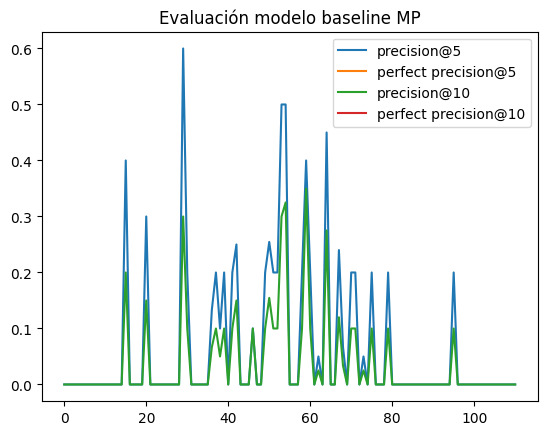

In [12]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = pdf['precision@5']
mdf['perfect precision@10'] = pdf['precision@10']
mdf[['precision@5', 'perfect precision@5', 'precision@10', 'perfect precision@10']].plot(title='Evaluación modelo baseline MP')
mdf.describe()

In [13]:
mdf[-LAST_FOLDS:].describe()

,fold,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,10,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.000000,0.0,0.0
mean,2023-04-03 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069653,NaN,NaN
min,2023-03-03 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068901,NaN,NaN
25%,2023-03-18 18:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069152,NaN,NaN
50%,2023-04-03 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069570,NaN,NaN
75%,2023-04-19 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.070037,NaN,NaN
max,2023-05-05 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.070544,NaN,NaN
std,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000594,NaN,NaN
